# Independent expenditures experiments

By Ben Welsh

## Import tools

In [43]:
import os
import requests
from datetime import datetime
from clint.textui import progress

In [44]:
import pandas
pandas.set_option('display.float_format', lambda x: '%.2f' % x)

In [45]:
import matplotlib.pyplot as plt
import matplotlib.dates as dates
%matplotlib inline

In [47]:
def download_csv_to_dataframe(name):
    """
    Accepts the name of a calaccess.download CSV and returns it as a pandas dataframe.
    """
    path = os.path.join(os.getcwd(), '{}.csv'.format(name))
    if not os.path.exists(path):
        url = "http://calaccess.download/latest/{}.csv".format(name)
        r = requests.get(url, stream=True)
        with open(path, 'w') as f:
            total_length = int(r.headers.get('content-length'))
            for chunk in progress.bar(r.iter_content(chunk_size=1024), expected_size=(total_length/1024) + 1): 
                if chunk:
                    f.write(chunk)
                    f.flush()
    return pandas.read_csv(path)

In [91]:
def remove_amended_filings(df):
    """
    Accepts a dataframe with FILING_ID and AMEND_ID files.
    
    Returns only the highest amendment for each unique filing id.
    """
    max_amendments = df.groupby('FILING_ID')['AMEND_ID'].agg("max").reset_index()
    merged_df = pandas.merge(df, max_amendments, how='inner', on=['FILING_ID', 'AMEND_ID'])
    print "Removed {} amendments".format(len(df)-len(merged_df))
    print "DataFrame now contains {} rows".format(len(merged_df))
    return merged_df

## Download quarterly filings

Independent expenditure committees are required to file [Form 461](http://calaccess.californiacivicdata.org/documentation/calaccess-forms/f461/). The summary totals from those filings are found in the [SMRY_CD](http://calaccess.californiacivicdata.org/documentation/calaccess-files/smry-cd/) file. 

In [80]:
quarterly_df = download_csv_to_dataframe("smry_cd")

## Basic information about the file

In [81]:
quarterly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8396322 entries, 0 to 8396321
Data columns (total 9 columns):
FILING_ID    int64
AMEND_ID     int64
LINE_ITEM    object
REC_TYPE     object
FORM_TYPE    object
AMOUNT_A     float64
AMOUNT_B     float64
AMOUNT_C     float64
ELEC_DT      object
dtypes: float64(3), int64(2), object(4)
memory usage: 576.5+ MB


In [82]:
quarterly_df.head()

,FILING_ID,AMEND_ID,LINE_ITEM,REC_TYPE,FORM_TYPE,AMOUNT_A,AMOUNT_B,AMOUNT_C,ELEC_DT
0,578572,0,12,SMRY,F460,209002.34,nan,nan,NaN
1,578572,0,13,SMRY,F460,10574.00,nan,nan,NaN
2,578572,0,14,SMRY,F460,0.00,nan,nan,NaN
3,578572,0,15,SMRY,F460,95797.92,nan,nan,NaN
4,578572,0,16,SMRY,F460,123778.42,nan,nan,NaN


## Frequency counts on the fields

In [85]:
quarterly_df.groupby(['FORM_TYPE'])['FILING_ID'].agg(['count'])

,count
FORM_TYPE,
401A,9675
401B,9550
401B-1,102
A,317239
B1,313058
B2,11799
B3,4142
C,233639
D,290726


## Filter down to only Form 461 filings

In [86]:
quarterly_ie_filings = quarterly_df[quarterly_df['FORM_TYPE'] == 'F461']

In [87]:
print len(quarterly_ie_filings)

115144


## Check what line items are recorded for this form

In [88]:
quarterly_ie_filings.groupby(['LINE_ITEM'])['FILING_ID'].agg(['count'])

,count
LINE_ITEM,
1,23045
2,22991
3,23045
4,23017
5,23046


Here's the paper form where those five line-items can be seen in the right-hand summary section. It looks to be that line three is the total made during the current reporting period.

![](https://assets.documentcloud.org/documents/2781361/pages/461-2016-01-p3-normal.gif)

## Filter down to those total line items

In [92]:
quarterly_ie_totals = quarterly_ie_filings[quarterly_ie_filings['LINE_ITEM'] == '3']

In [93]:
print len(quarterly_ie_totals)

23045


## Prepare the table for analysis

In [95]:
real_ie_totals = remove_amended_filings(quarterly_ie_totals)

Removed 3042 amendments
DataFrame now contains 20003 rows


### Exclude filings by major donors and other filers

In [96]:
print "TK"

TK


## Download late independent expenditure filings

They are filed via [Form 496](http://calaccess.californiacivicdata.org/documentation/calaccess-forms/f496/) for all independent expenditures over $1,000 in the 90 days prior to an election. The data are recorded in the [S496 file](http://calaccess.californiacivicdata.org/documentation/calaccess-files/s496-cd/). 

In [97]:
late_df = download_csv_to_dataframe("s496_cd")

### Convert the date field to a datetime object

In [98]:
late_df['EXP_DATE'] = pandas.to_datetime(
    late_df['EXP_DATE'],
    errors="coerce"
)

## Basic information about the file

In [99]:
late_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38810 entries, 0 to 38809
Data columns (total 12 columns):
FILING_ID     38810 non-null int64
AMEND_ID      38810 non-null int64
LINE_ITEM     38810 non-null int64
REC_TYPE      38810 non-null object
FORM_TYPE     38810 non-null object
TRAN_ID       38810 non-null object
AMOUNT        38779 non-null float64
EXP_DATE      38778 non-null datetime64[ns]
EXPN_DSCR     38619 non-null object
MEMO_CODE     177 non-null object
MEMO_REFNO    11523 non-null object
DATE_THRU     1445 non-null object
dtypes: datetime64[ns](1), float64(1), int64(3), object(7)
memory usage: 3.6+ MB


In [100]:
late_df.head()

,FILING_ID,AMEND_ID,LINE_ITEM,REC_TYPE,FORM_TYPE,TRAN_ID,AMOUNT,EXP_DATE,EXPN_DSCR,MEMO_CODE,MEMO_REFNO,DATE_THRU
0,1048489,0,2,S496,F496,EDT72,7200.00,2004-10-18,Productions Costs,NaN,NaN,NaN
1,1048489,0,3,S496,F496,EDT67,39302.68,2004-10-18,Media Buys,NaN,NaN,NaN
2,1048490,0,1,S496,F496,EDT70,750.00,2004-10-18,Polling,NaN,NaN,NaN
3,1048490,0,2,S496,F496,NON4011,9500.00,2004-10-18,Polling,NaN,NaN,NaN
4,1048490,0,3,S496,F496,EDT60,4000.00,2004-10-18,Production Costs,NaN,NaN,NaN


## Frequency counts on the fields

In [102]:
df.groupby(['REC_TYPE'])['FILING_ID'].agg(['count'])

,count
REC_TYPE,
SMRY,8396322


In [103]:
late_df.groupby(['FORM_TYPE'])['FILING_ID'].agg(['count'])

,count
FORM_TYPE,
F496,38810


In [104]:
late_df.groupby(['LINE_ITEM'])['FILING_ID'].agg(['count'])

,count
LINE_ITEM,
1,19202
2,6984
3,3833
4,2309
5,1454
6,926
7,681
8,487
9,380


## Preparing the file for analysis

In [110]:
real_late_filings = remove_amended_filings(late_df)

Removed 6844 amendments
DataFrame now contains 31966 rows


### Figure out what to do with the different line numbers

Let's start by pulling the filing with the most line items.

In [111]:
real_late_filings[real_late_filings['LINE_ITEM'] == 104]

,FILING_ID,AMEND_ID,LINE_ITEM,REC_TYPE,FORM_TYPE,TRAN_ID,AMOUNT,EXP_DATE,EXPN_DSCR,MEMO_CODE,MEMO_REFNO,DATE_THRU
19928,1717649,0,104,S496,F496,EDT735,2.24,2012-10-30,Data File,NaN,NaN,NaN


In [112]:
longest_late_filing = real_late_filings[real_late_filings['FILING_ID'] == 1717649]

In [113]:
longest_late_filing

,FILING_ID,AMEND_ID,LINE_ITEM,REC_TYPE,FORM_TYPE,TRAN_ID,AMOUNT,EXP_DATE,EXPN_DSCR,MEMO_CODE,MEMO_REFNO,DATE_THRU
19825,1717649,0,1,S496,F496,PDT575,17.95,2012-11-01,Voter Guide,NaN,NaN,NaN
19826,1717649,0,2,S496,F496,PDT668,11.94,2012-11-02,Voter Guide,NaN,NaN,NaN
19827,1717649,0,3,S496,F496,PDT917,40.00,2012-10-29,Phone Banking,NaN,NaN,NaN
19828,1717649,0,4,S496,F496,PDT918,40.00,2012-10-31,Phone Banking,NaN,NaN,NaN
19829,1717649,0,5,S496,F496,PDT919,40.00,2012-11-03,Phone Banking,NaN,NaN,NaN
19830,1717649,0,6,S496,F496,PDT1038,40.00,2012-10-22,Phone Banking,NaN,NaN,NaN
19831,1717649,0,7,S496,F496,PDT1039,40.00,2012-10-24,Phone Banking,NaN,NaN,NaN
19832,1717649,0,8,S496,F496,PDT1051,40.00,2012-10-22,Phone Banking,NaN,NaN,NaN
19833,1717649,0,9,S496,F496,PDT1091,40.00,2012-10-26,Phone Banking,NaN,NaN,NaN
19834,1717649,0,10,S496,F496,PDT1092,40.00,2012-10-27,Phone Banking,NaN,NaN,NaN


That filing can be reviewed [here](http://cal-access.ss.ca.gov/PDFGen/pdfgen.prg?filingid=1717649&amendid=0). The expenditure count is 104, which matches this data. There are three late contributions at the bottom that do not appear in this table and must be recorded elsewhere.

## Summing up the money

In [114]:
real_late_filings['AMOUNT'].sum()

428599820.21000004

### Spending by year

In [115]:
def trim_to_year(row):
    try:
        return row['EXP_DATE'].year
    except TypeError:
        return pandas.NaN

real_late_filings["year"] = real_late_filings.apply(trim_to_year, axis=1) 

In [118]:
late_by_year = real_late_filings.groupby('year')['AMOUNT'].agg('sum')

In [119]:
late_by_year = late_by_year.to_frame('sum').reset_index()

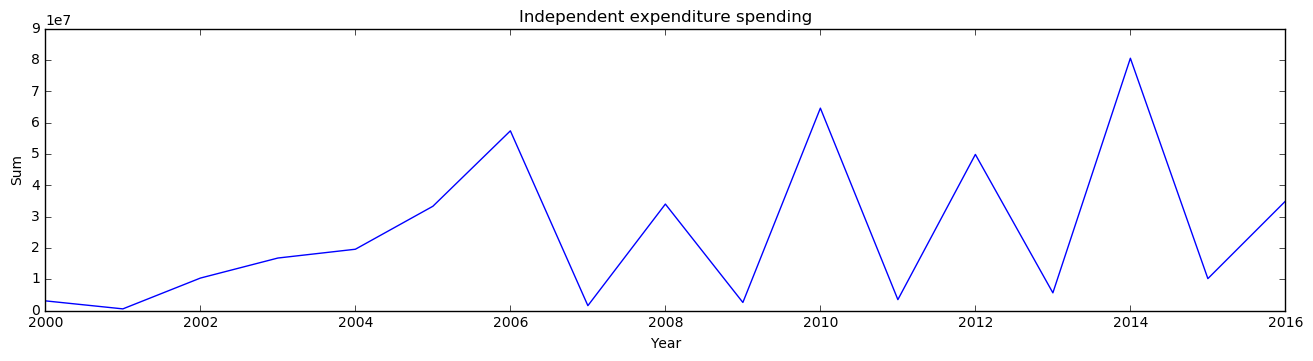

In [120]:
fig = plt.figure(1, figsize=(16,8))
ax1 = fig.add_subplot(211)
ax1.plot(late_by_year['year'], late_by_year['sum'])
ax1.set_title('Independent expenditure spending')
ax1.set_xlabel('Year')
ax1.set_ylabel('Sum')

### Spending by month

In [121]:
def trim_to_month(row):
    try:
        return datetime(year=row['EXP_DATE'].year, month=row['EXP_DATE'].month, day=1)
    except TypeError:
        return pandas.NaT

real_late_filings["month"] = real_late_filings.apply(trim_to_month, axis=1) 

In [122]:
late_by_month = real_late_filings.groupby('month')['AMOUNT'].agg('sum')

In [123]:
late_by_month = late_by_month.to_frame('sum').reset_index()

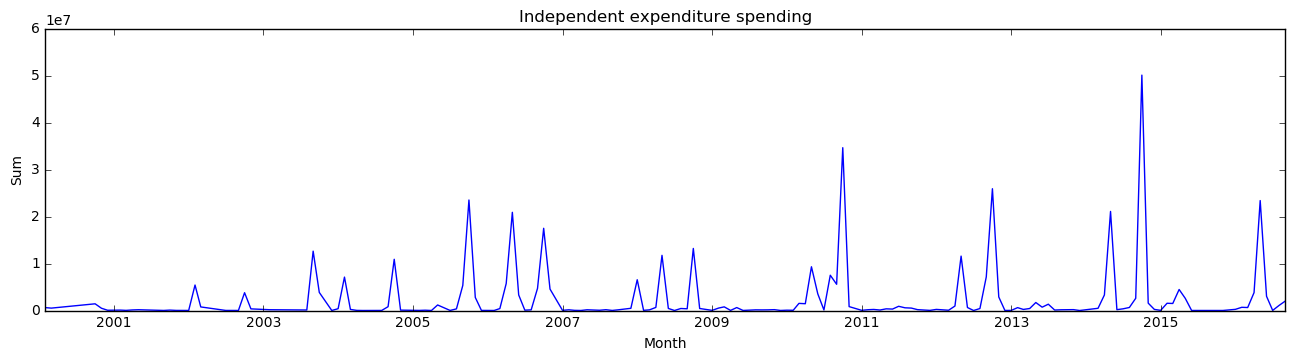

In [124]:
fig = plt.figure(1, figsize=(16,8))
ax1 = fig.add_subplot(211)
ax1.plot(late_by_month['month'], late_by_month['sum'])
ax1.set_title('Independent expenditure spending')
ax1.set_xlabel('Month')
ax1.set_ylabel('Sum')

## Summing up the expenditure types

In [125]:
by_description = real_late_filings.groupby('EXPN_DSCR')['AMOUNT'].agg('sum')

In [126]:
by_description = by_description.to_frame('sum').reset_index()

In [127]:
by_description.sort_values("sum", ascending=False)

,EXPN_DSCR,sum
2617,Mailer,39900203.98
2961,Media Buy,20229264.70
5160,T.V. or Cable Airtime and Production Costs,14992254.03
2307,MAILER,14905949.58
5189,TEL Television Airtime and Production Costs,14865505.67
5316,TV/Cable Buy,9221000.00
4488,Radio,9128839.75
537,Campaign Literature and Mailings,8714907.45
2033,LIT,8040769.95
4910,Slate Mailer,7150124.40
